# Import thư viện

In [1]:
import numpy                 as np
import pandas                as pd
import scipy                 as scp
import seaborn               as sns
import matplotlib.pyplot as plt
import networkx as nx
import time
from pyECLAT import ECLAT
from collections import Counter
from itertools import combinations
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder

In [2]:
!pip install networkx

In [3]:
!pip install pyECLAT

In [4]:
import warnings
warnings.filterwarnings('ignore') # tắt những cảnh báo

# Đọc file

In [5]:
df = pd.read_csv('Groceries 3.csv')

In [6]:
df

,Unnamed: 0,Apple,Bread,Butter,Cheese,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt,Chocolate
0,0,False,True,False,False,True,True,False,True,False,False,False,False,True,False,True,True
1,1,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,2,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,True
3,3,False,False,True,True,False,True,False,False,False,True,True,True,False,False,False,False
4,4,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,994,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True
995,995,True,False,False,False,True,False,False,False,True,True,True,False,False,False,True,False
996,996,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,True
997,997,False,False,True,True,True,False,True,True,True,False,True,False,True,False,True,True


In [7]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [8]:
transactions = []
for i in range(df.shape[0]):
    transaction = list(df.columns[df.iloc[i] == 1])
    transactions.append(transaction)

In [9]:
transactions 

[['Bread', 'Corn', 'Dill', 'Ice cream', 'Sugar', 'Yogurt', 'Chocolate'],
 ['Milk'],
 ['Apple', 'Butter', 'Dill', 'Ice cream', 'Milk', 'Yogurt', 'Chocolate'],
 ['Butter', 'Cheese', 'Dill', 'Milk', 'Nutmeg', 'Onion'],
 ['Apple', 'Bread'],
 ['Apple',
  'Bread',
  'Butter',
  'Cheese',
  'Dill',
  'Ice cream',
  'Nutmeg',
  'Unicorn',
  'Yogurt',
  'Chocolate'],
 ['Butter',
  'Eggs',
  'Ice cream',
  'Kidney Beans',
  'Milk',
  'Nutmeg',
  'Onion',
  'Yogurt'],
 ['Apple', 'Cheese', 'Eggs', 'Nutmeg', 'Sugar', 'Yogurt'],
 ['Apple',
  'Corn',
  'Dill',
  'Eggs',
  'Ice cream',
  'Milk',
  'Nutmeg',
  'Onion',
  'Sugar',
  'Unicorn',
  'Yogurt',
  'Chocolate'],
 ['Apple',
  'Dill',
  'Eggs',
  'Ice cream',
  'Milk',
  'Onion',
  'Sugar',
  'Unicorn',
  'Chocolate'],
 ['Apple', 'Bread', 'Cheese', 'Ice cream', 'Sugar', 'Unicorn'],
 ['Apple',
  'Bread',
  'Cheese',
  'Dill',
  'Eggs',
  'Ice cream',
  'Kidney Beans',
  'Nutmeg',
  'Sugar',
  'Yogurt',
  'Chocolate'],
 ['Onion', 'Unicorn', 'Chocol

# Tần suất xuất hiện của các item

In [10]:
#Số lần xuất hiện của các item
item_counts = np.sum(df, axis=0)


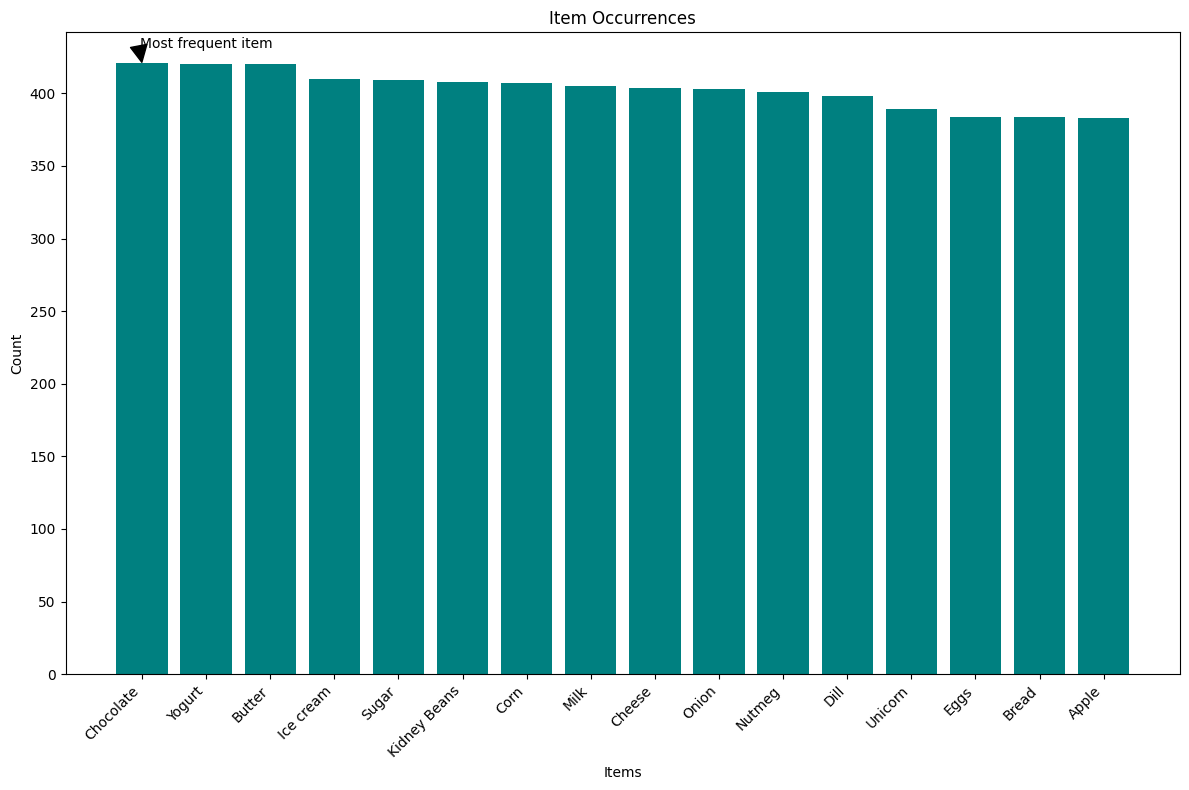

In [11]:
items = df.columns.tolist()

#Sắp xếp các mặt hàng theo số lần xuất hiện
sorted_indices = np.argsort(item_counts)[::-1]
sorted_items = [items[i] for i in sorted_indices]
sorted_counts = item_counts[sorted_indices]

plt.figure(figsize=(12, 8))  # Tăng kích thước để cải thiện tính rõ ràng
plt.bar(sorted_items, sorted_counts, color='teal') #màu sắc
plt.title('Item Occurrences')
plt.xlabel('Items')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

#Thêm chú thích cho mặt hàng phổ biến nhất
plt.annotate('Most frequent item', xy=(0, sorted_counts[0]), xytext=(1, sorted_counts[0] + 10),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center')

plt.tight_layout()
plt.show()

In [12]:
# Tạo một danh sách tất cả các mặt hàng duy nhất từ tất cả các giao dịch, sau đó sắp xếp chúng
all_items = sorted(set(item for transaction in transactions for item in transaction))

# Tạo một bộ đếm để giữ số lượng xuất hiện của mỗi cặp sản phẩm
pair_counts = Counter()

# Đếm số lần xuất hiện của mỗi cặp trong các giao dịch
for transaction in transactions:
    # Sử dụng hàm combinations để tìm tất cả các cặp duy nhất trong giao dịch
    pairs = combinations(sorted(transaction), 2)
    pair_counts.update(pairs)

# Tạo một DataFrame trống với các hàng và cột là các mặt hàng
item_matrix = pd.DataFrame(index=all_items, columns=all_items).fillna(0)

# Điền vào DataFrame với số lượng các cặp
for (item1, item2), count in pair_counts.items():
    item_matrix.at[item1, item2] = count
    item_matrix.at[item2, item1] = count  # Cập nhật để ma trận là đối xứng

# Hiển thị DataFrame kết quả
item_matrix.astype(int)  # Chuyển đổi sang kiểu int để hiển thị

,Apple,Bread,Butter,Cheese,Chocolate,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Sugar,Unicorn,Yogurt
Apple,0,154,188,162,183,186,179,156,172,176,184,172,167,182,166,187
Bread,154,0,180,173,185,174,160,157,181,167,174,171,178,179,168,193
Butter,188,180,0,182,202,191,175,173,207,202,198,198,197,196,182,191
Cheese,162,173,182,0,186,182,177,169,187,200,172,192,185,187,170,181
Chocolate,183,185,202,186,0,192,199,182,202,191,211,186,196,188,186,198
Corn,186,174,191,182,192,0,180,180,192,195,193,181,184,187,177,190
Dill,179,160,175,177,199,180,0,157,185,172,190,173,192,179,168,185
Eggs,156,157,173,169,182,180,157,0,157,169,176,172,174,170,168,186
Ice cream,172,181,207,187,202,192,185,157,0,196,177,187,192,195,185,182
Kidney Beans,176,167,202,200,191,195,172,169,196,0,199,189,170,187,184,194


# Sử dụng thư viện ECLAT

In [13]:
df2 = pd.DataFrame(transactions )
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Bread,Corn,Dill,Ice cream,Sugar,Yogurt,Chocolate,None,None,None,None,None,None
1,Milk,None,None,None,None,None,None,None,None,None,None,None,None
2,Apple,Butter,Dill,Ice cream,Milk,Yogurt,Chocolate,None,None,None,None,None,None
3,Butter,Cheese,Dill,Milk,Nutmeg,Onion,None,None,None,None,None,None,None
4,Apple,Bread,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,Bread,Eggs,Unicorn,Chocolate,None,None,None,None,None,None,None,None,None
995,Apple,Corn,Kidney Beans,Milk,Nutmeg,Yogurt,None,None,None,None,None,None,None
996,Apple,Corn,Dill,Sugar,Chocolate,None,None,None,None,None,None,None,None
997,Butter,Cheese,Corn,Eggs,Ice cream,Kidney Beans,Nutmeg,Sugar,Yogurt,Chocolate,None,None,None


In [14]:
eclat = ECLAT(df2, verbose=True)

100%|██████████| 17/17 [00:00<00:00, 2838.28it/s]

In [15]:
index, support = eclat.fit(min_support=0.11,min_combination=2)

Combination 2 by 2


120it [00:00, 325.39it/s]


Combination 3 by 3


560it [00:01, 517.36it/s]


In [16]:
data = pd.DataFrame(list(index.items()), columns=['Items', 'Tidset'])
data

,Items,Tidset
0,Milk & Unicorn,"[8, 9, 19, 22, 24, 26, 28, 30, 31, 45, 50, 64,..."
1,Milk & Cheese,"[3, 22, 26, 50, 58, 61, 62, 67, 69, 75, 84, 91..."
2,Milk & Chocolate,"[2, 8, 9, 22, 25, 26, 28, 30, 37, 43, 50, 56, ..."
3,Milk & Corn,"[8, 19, 24, 26, 30, 37, 43, 45, 50, 56, 62, 65..."
4,Milk & Apple,"[2, 8, 9, 31, 43, 50, 58, 60, 61, 65, 75, 84, ..."
...,...,...
117,Ice cream & Bread,"[0, 5, 10, 11, 16, 19, 22, 23, 29, 34, 39, 43,..."
118,Ice cream & Yogurt,"[0, 2, 5, 6, 8, 11, 13, 22, 29, 36, 39, 57, 65..."
119,Bread & Yogurt,"[0, 5, 11, 22, 24, 25, 28, 29, 31, 39, 41, 48,..."
120,Milk & Chocolate & Dill,"[2, 8, 9, 22, 30, 43, 50, 56, 62, 67, 75, 86, ..."


In [17]:
df_sup = pd.DataFrame(list(support.items()), columns=['Items', 'Support'])
df_sup = df_sup.sort_values(by='Support', ascending=False).reset_index()
df_sup = df_sup.drop(columns = 'index')
df_sup

,Items,Support
0,Milk & Chocolate,0.211211
1,Butter & Ice cream,0.207207
2,Chocolate & Butter,0.202202
3,Butter & Kidney Beans,0.202202
4,Chocolate & Ice cream,0.202202
...,...,...
117,Eggs & Ice cream,0.157157
118,Apple & Eggs,0.156156
119,Apple & Bread,0.154154
120,Milk & Chocolate & Dill,0.114114


# Cài đặt thuật toán ECLAT

In [18]:
def eclat_setup(dataset, min_support, min_combination=2):
    transactions = len(dataset)
    min_support_count = min_support * transactions

    items = {}
    for transaction in dataset:
        for item in transaction:
            items.setdefault(item, 0)
            items[item] += 1

    frequent_items = {item: count for item, count in items.items() if count >= min_support_count}

    frequent_itemsets = {}
    for size in range(min_combination, len(frequent_items) + 1):
        itemsets = [set(itemset) for itemset in combinations(frequent_items.keys(), size)]
        for itemset in itemsets:
            count = sum(all(item in transaction for item in itemset) for transaction in dataset)
            if count >= min_support_count:
                frequent_itemsets[tuple(sorted(itemset))] = count / transactions

    return frequent_itemsets


Chọn ngưỡng minSup cho bài toán

In [19]:
min_support_values = []
size_association = []
for j in range(10, 22):
    i = j / 100  # Convert to the desired scale
    rule = eclat_setup(transactions, min_support = i)
    df_mode = pd.DataFrame.from_dict(rule, orient='index', columns = ['Support'])
    length = len(df_mode)
    min_support_values.append(i)
    size_association.append(length)
    

In [20]:
result_df_mode = pd.DataFrame({
    'minsup': min_support_values,
    'size_association': size_association,
})
result_df_mode

,minsup,size_association
0,0.10,153
1,0.11,122
2,0.12,120
3,0.13,120
4,0.14,120
5,0.15,120
6,0.16,115
7,0.17,104
8,0.18,78
9,0.19,37


In [21]:
min_support = 0.01
result_eclat = eclat_setup(transactions, min_support)

Chọn ngưỡng min support sắp xỉ 0 để lưu lại tất cả các kết quả của thuật toán

In [22]:
df_eclat = pd.DataFrame.from_dict(result_eclat, orient='index', columns = ['Support'])
df_eclat.sort_values(by=['Support'], ascending=True)

,Support
"(Apple, Eggs, Kidney Beans, Milk, Onion, Unicorn, Yogurt)",0.010010
"(Apple, Butter, Chocolate, Ice cream, Milk, Nutmeg)",0.010010
"(Apple, Butter, Chocolate, Ice cream, Milk, Onion)",0.010010
"(Apple, Butter, Chocolate, Eggs, Ice cream, Milk)",0.010010
"(Apple, Cheese, Chocolate, Ice cream, Milk, Onion)",0.010010
...,...
"(Butter, Kidney Beans)",0.202202
"(Butter, Chocolate)",0.202202
"(Chocolate, Ice cream)",0.202202
"(Butter, Ice cream)",0.207207


In [23]:
result_eclat = eclat_setup(transactions, 0.11)
df_eclat = pd.DataFrame.from_dict(result_eclat, orient='index', columns = ['Support'])
df_eclat.sort_values(by=['Support'], ascending= False)

,Support
"(Chocolate, Milk)",0.211211
"(Butter, Ice cream)",0.207207
"(Butter, Kidney Beans)",0.202202
"(Butter, Chocolate)",0.202202
"(Chocolate, Ice cream)",0.202202
...,...
"(Eggs, Ice cream)",0.157157
"(Apple, Eggs)",0.156156
"(Apple, Bread)",0.154154
"(Chocolate, Dill, Milk)",0.114114


# Lattice Graph

In [24]:
# Sắp xếp df_eclat theo 'Support' và lấy ra top N
top_n = 10
top_rules = df_eclat.sort_values('Support', ascending=False).head(top_n)

In [25]:
top_rules

,Support
"(Chocolate, Milk)",0.211211
"(Butter, Ice cream)",0.207207
"(Butter, Kidney Beans)",0.202202
"(Butter, Chocolate)",0.202202
"(Chocolate, Ice cream)",0.202202
"(Cheese, Kidney Beans)",0.200200
"(Kidney Beans, Milk)",0.199199
"(Chocolate, Dill)",0.199199
"(Chocolate, Yogurt)",0.198198
"(Butter, Milk)",0.198198


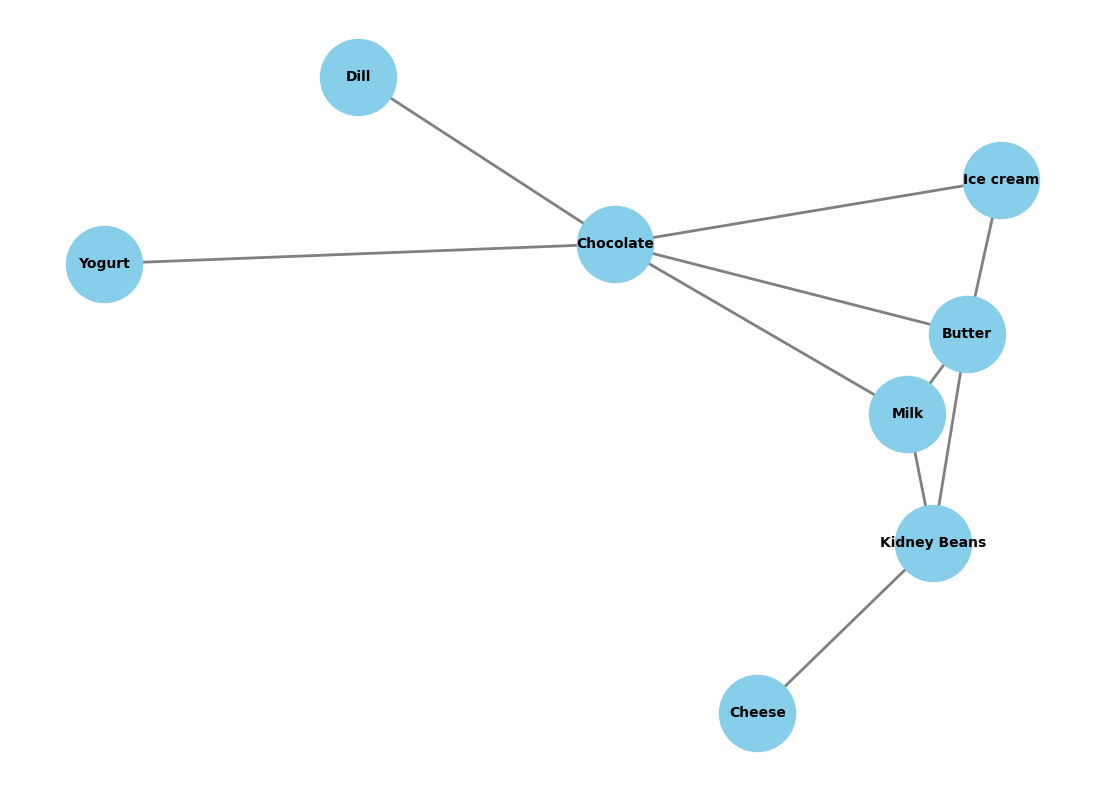

In [26]:
#Tạo graph
G = nx.Graph()

# Thêm các nút và cạnh vào graph
for index, row in top_rules.iterrows():
    items = index  # Lấy các items từ index của DataFrame
    for item in items:
        G.add_node(item)  # Thêm nút cho mỗi item
    # Thêm cạnh giữa các items trong cùng một tuple
    # Vì mỗi tuple có 2 items, ta sẽ thêm cạnh giữa cặp items này
    G.add_edge(items[0], items[1])
#Spring layout để bố trí các nút
pos = nx.spring_layout(G, k=0.25, iterations=20)

#Vẽ graph
fig, ax = plt.subplots(figsize=(14, 10))
nx.draw(G, pos, ax=ax, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', width=2, edge_color='gray')

#Hiển thị
plt.show()

Tính Độ tin cậy Confidence với ngưỡng tin cậy minConf

In [27]:
total_transactions = len(transactions)

In [28]:
item_counts


Apple           383
Bread           384
Butter          420
Cheese          404
Corn            407
Dill            398
Eggs            384
Ice cream       410
Kidney Beans    408
Milk            405
Nutmeg          401
Onion           403
Sugar           409
Unicorn         389
Yogurt          420
Chocolate       421
dtype: int64

In [29]:
def calculate_confidence(top_rules_df, min_conf, total_transactions):

    # Bây giờ hãy tính độ tin cậy cho từng rule
    confidence_list = []
    for itemset, support in zip(top_rules_df.index, top_rules_df['Support']):
        for item in itemset:
            # Phần còn lại của itemet là consequent
            consequent = tuple(set(itemset) - set([item]))
            # Confience là độ hỗ trợ của toàn bộ tập được chia cho độ hỗ trợ của Antecedent
            confidence = (support * total_transactions) / (item_counts[item])
            if confidence >= min_conf:
                confidence_list.append((item, consequent, support,confidence))

    # Tạo DataFrame
    confidence_df = pd.DataFrame(confidence_list, columns=['Antecedent', 'Consequent', 'Support','Confidence'])
    
    # Xóa dấu ngoặc đơn khỏi cột Consequent
    confidence_df['Consequent'] = confidence_df['Consequent'].apply(lambda x: str(x).strip("(',')"))
    
    return confidence_df

In [30]:
# Tính toán DataFrame cho độ tin cậy confidence
confidence_df = calculate_confidence(top_rules, 0.495, total_transactions)

# Hiển thị kết quả
confidence_df

,Antecedent,Consequent,Support,Confidence
0,Chocolate,Milk,0.211211,0.501188
1,Milk,Chocolate,0.211211,0.520988
2,Ice cream,Butter,0.207207,0.504878
3,Kidney Beans,Butter,0.202202,0.495098
4,Cheese,Kidney Beans,0.200200,0.495050
5,Dill,Chocolate,0.199199,0.500000


Tính độ tương quan Lift

In [31]:
def calculate_lift(top_rules_df, total_transactions):
    
    # tính lift cho từng rule
    lift_list = []
    for antecedent, consequent, confidence in zip(top_rules_df['Antecedent'], top_rules_df['Consequent'], top_rules_df['Confidence']):

        # Tính toán lift
        lift_numerator = confidence
        sup_consequent = item_counts[consequent]/total_transactions
        lift = lift_numerator / sup_consequent
        
        lift_list.append((antecedent, consequent, lift))
    
    # Tạo DataFrame
    lift_df = pd.DataFrame(lift_list, columns=['Antecedent', 'Consequent', 'Lift'])
    
    # Xóa dấu ngoặc đơn khỏi cột Consequent
    lift_df['Consequent'] = lift_df['Consequent'].apply(lambda x: str(x).strip("(',')"))
    
    return lift_df

In [32]:
# Tính toán DataFrame cho độ tương quan Lift
lift_df = calculate_lift(confidence_df, total_transactions)

# Hiển thị kết quả
lift_df

,Antecedent,Consequent,Lift
0,Chocolate,Milk,1.236263
1,Milk,Chocolate,1.236263
2,Ice cream,Butter,1.200889
3,Kidney Beans,Butter,1.177626
4,Cheese,Kidney Beans,1.212143
5,Dill,Chocolate,1.186461


In [33]:
merge_df = pd.merge(confidence_df, lift_df, how='inner')

merge_df

,Antecedent,Consequent,Support,Confidence,Lift
0,Chocolate,Milk,0.211211,0.501188,1.236263
1,Milk,Chocolate,0.211211,0.520988,1.236263
2,Ice cream,Butter,0.207207,0.504878,1.200889
3,Kidney Beans,Butter,0.202202,0.495098,1.177626
4,Cheese,Kidney Beans,0.200200,0.495050,1.212143
5,Dill,Chocolate,0.199199,0.500000,1.186461


DATA MINING:

- Độ mạnh của Luật Kết Hợp: Từ kết quả thuật toán Eclat, các cạnh trên biểu đồ không chỉ thể hiện sự tồn tại của một luật kết hợp mà còn mức độ hỗ trợ của chúng.Mặt hàng "Bơ" và "Sô cô la" được nối với nhiều sản phẩm khác, cho thấy đây là các mặt hàng trung tâm trong các giao dịch mua bán. Phân tích này có thể được sâu hơn nếu ta xem xét thêm độ tin cậy (confidence) và lift của các luật để đánh giá sức mạnh và độ hấp dẫn của chúng.


- Mô Hình Mua Hàng: Các mô hình mua hàng phổ biến xuất hiện trong biểu đồ, như "Bơ" và "Kem" hoặc "Sô cô la" và "Sữa", cung cấp thông tin quý giá về thói quen tiêu dùng. Nếu một mô hình mua hàng cụ thể lặp lại nhiều lần, đó có thể là một dấu hiệu cho thấy một nhóm khách hàng với nhu cầu cụ thể.


Nhận Định Kinh Doanh (Business Insights):


- Tối ưu hóa quản lý hàng tồn kho: Sự hiểu biết về sự kết hợp sản phẩm có thể giúp trong việc quản lý hàng tồn kho. Ví dụ, nếu "Bơ" và "Sô cô la" thường xuyên được mua cùng nhau, cửa hàng có thể giữ một lượng hàng tồn kho phù hợp để đảm bảo không bị thiếu hụt, nhất là trong các dịp lễ, tết hoặc sự kiện khuyến mãi.


- Chiến Lược Đặt Sản Phẩm: Dữ liệu này có thể hỗ trợ trong việc sắp xếp sản phẩm một cách chiến lược trong cửa hàng. Ví dụ, đặt "Phô mai" gần "Đậu" có thể tăng cơ hội bán chéo giữa hai mặt hàng này.


- Chiến Dịch Marketing Nhắm Đúng Đối Tượng: Phân tích về các kết hợp mua hàng còn có thể hỗ trợ cho các chiến dịch marketing nhắm đúng đối tượng. Cửa hàng có thể gửi ưu đãi cho những khách hàng đã mua "Sô cô la" để kích thích họ mua thêm "Sữa" hoặc "Kem" trong lần mua tiếp theo.


- Phát Triển Gói Sản Phẩm Mới: Biết được sản phẩm nào thường được mua cùng nhau cho phép cửa hàng tạo ra các gói sản phẩm mới, chẳng hạn như một bộ quà tặng nấu ăn kèm "Bơ", "Sô cô la", và "Nhục đậu khấu" cho các dịp đặc biệt.


- Phân Khúc Khách Hàng Cá nhân hóa: Dữ liệu mô hình mua hàng cũng có thể được sử dụng để phân loại khách hàng và tạo ra các đề nghị cá nhân hóa. Khách hàng mua "Bơ" thường xuyên có thể được nhận các ưu đãi đặc biệt cho "Sữa" hoặc ngược lại.


- Chiến Lược Định Giá Động: Phân tích sự kết hợp có thể cung cấp thông tin cho việc định giá động, tận dụng các thông tin từ các mô hình mua hàng để điều chỉnh giá cả cho phù hợp với cầu và cung cũng như tối ưu hóa lợi nhuận.

# Cải thiện THUẬT TOÁN

SỬ DỤNG TRIE NODE ĐỂ GIẢM THỜI GIAN CHẠY

In [34]:
class TrieNode:
    def __init__(self, item, count):
        self.item = item
        self.count = count
        self.children = {}

def insert_transaction(root, transaction):
    for itemset in combinations(transaction, 2):
        node = root
        for item in itemset:
            if item is not None:
                if item in node.children:
                    node = node.children[item]
                    node.count += 1
                else:
                    new_node = TrieNode(item, 1)
                    node.children[item] = new_node
                    node = new_node

def find_frequent_itemsets(node, min_support_count, current_itemset, frequent_itemsets, transactions):
    if node.item is not None and node.count >= min_support_count and len(current_itemset) > 1:
        frequent_itemsets[tuple(sorted([item for item in current_itemset if item is not None] + [node.item]))] = node.count / transactions

    for _, child_node in node.children.items():
        find_frequent_itemsets(child_node, min_support_count, [node.item] + current_itemset, frequent_itemsets, transactions)

def eclat_trie(dataset, min_support):
    transactions = len(dataset)
    min_support_count = min_support * transactions

    root = TrieNode(None, 0)
        
    for transaction in dataset:
        insert_transaction(root, transaction)

    frequent_itemsets = {}
    find_frequent_itemsets(root, min_support_count, [], frequent_itemsets, transactions)

    return frequent_itemsets

Đo lường thời gian chạy của thuật toán trước khi cải thiện và sau khi cải thiện 

In [35]:
min_support = 0.1
start_time = time.time()
result = eclat_trie(transactions, min_support)
elapsed_time_eclat2 = time.time() - start_time
#Eclat
start_time = time.time()
result_eclat = eclat_setup(transactions, min_support)
elapsed_time_eclat = time.time() - start_time

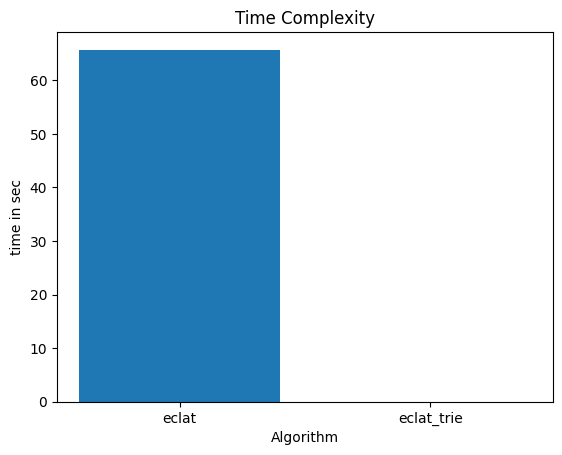

In [36]:
x = ["eclat", "eclat_trie"]
y = [elapsed_time_eclat, elapsed_time_eclat2]

plt.bar(x, y)
plt.xlabel("Algorithm")
plt.ylabel("time in sec")
plt.title("Time Complexity")
plt.show()

In [37]:
min_support = 0.11

result = eclat_trie(transactions, min_support)
df_test = pd.DataFrame.from_dict(result, orient='index', columns = ['Support'])
df_test

,Support
"(Bread, Corn)",0.174174
"(Bread, Dill)",0.160160
"(Bread, Ice cream)",0.181181
"(Bread, Sugar)",0.179179
"(Bread, Yogurt)",0.193193
...,...
"(Kidney Beans, Unicorn)",0.184184
"(Onion, Yogurt)",0.192192
"(Onion, Sugar)",0.190190
"(Onion, Unicorn)",0.175175
